In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt

# Signal-in-white-noise model: simulation with a uniform prior

In [1]:
N = 200 # number of observed coefficients
tau = 1
n = 500 # size of the dataset
m = 30 # number of machines
alpha = 1.5 # smoothness parameter


In [3]:
# signal
theta = tau * (np.random.random(N) * 2 - 1) / (np.arange(1,N+1,1) ** (alpha + 0.5))

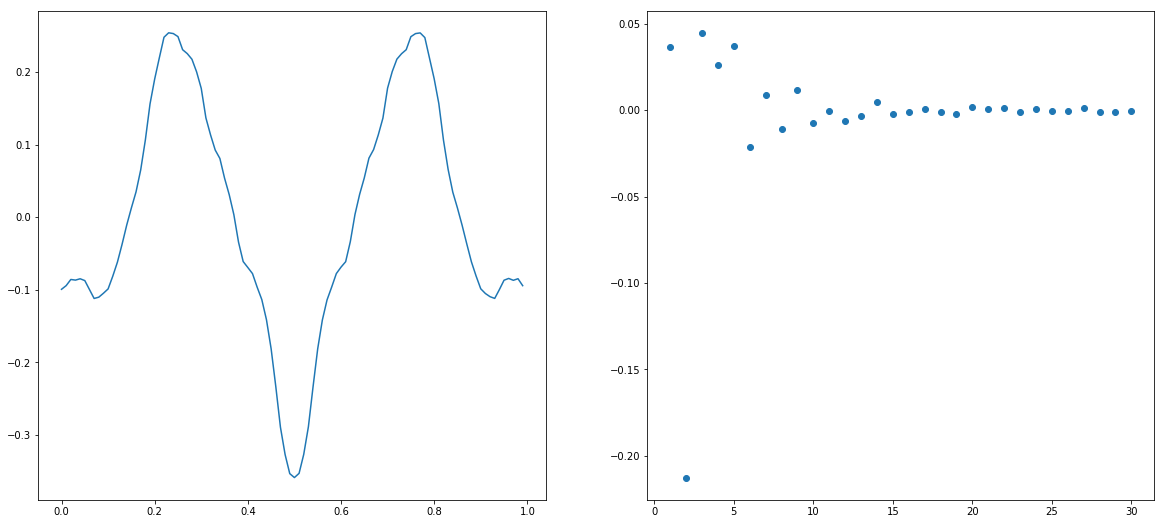

In [34]:
# plot of the signal and the coefficients

fig, ax = plt.subplots(1,2, figsize=(20/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
Y = [np.sum(theta[:N//2] * np.cos(2*np.pi*(np.arange(1,N//2+1,1) * x)))
     + np.sum(theta[N//2:] * np.sin(2*np.pi*(np.arange(1,N//2+1,1) * x))) for x in X]
a.plot(X,Y)

a = ax[1]
K = np.arange(1,N+1,1)
a.plot(K[:30],theta[:30],'o')

In [19]:
np.cos(2*np.pi*(np.arange(1,N+1,1) * 0.1))

array([ 0.80901699,  0.30901699, -0.30901699, -0.80901699, -1.        ,
       -0.80901699, -0.30901699,  0.30901699,  0.80901699,  1.        ,
        0.80901699,  0.30901699, -0.30901699, -0.80901699, -1.        ,
       -0.80901699, -0.30901699,  0.30901699,  0.80901699,  1.        ,
        0.80901699,  0.30901699, -0.30901699, -0.80901699, -1.        ,
       -0.80901699, -0.30901699,  0.30901699,  0.80901699,  1.        ,
        0.80901699,  0.30901699, -0.30901699, -0.80901699, -1.        ,
       -0.80901699, -0.30901699,  0.30901699,  0.80901699,  1.        ,
        0.80901699,  0.30901699, -0.30901699, -0.80901699, -1.        ,
       -0.80901699, -0.30901699,  0.30901699,  0.80901699,  1.        ,
        0.80901699,  0.30901699, -0.30901699, -0.80901699, -1.        ,
       -0.80901699, -0.30901699,  0.30901699,  0.80901699,  1.        ,
        0.80901699,  0.30901699, -0.30901699, -0.80901699, -1.        ,
       -0.80901699, -0.30901699,  0.30901699,  0.80901699,  1.  